# Actors matching

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import face_recognition
from ast import literal_eval
from annoy import AnnoyIndex
from process_images import get_image

In [73]:
def show_image(image, title: str = None, bbox: list = None):
    plt.imshow(image)
    ax = plt.gca()
    if title:
        ax.title.set_text(title)
    plt.axis("off")

    if bbox:
        # Create a Rectangle patch
        xy = (bbox[3], bbox[2])
        w = bbox[1] - bbox[3]
        h = bbox[0] - bbox[2]
        rect = patches.Rectangle(xy, w, h, linewidth=1, edgecolor='r', facecolor='none')

        # Add the patch to the Axes
        ax.add_patch(rect)

def show_image_from_url(url, title: str = None, bbox: list = None):
    img = get_image(url)
    show_image(img, title, bbox)

In [74]:
def parse_embeddings(x):
    if x:
        return literal_eval(x)

In [75]:
df = pd.read_csv("data/actors_embeddings.csv", converters={"embeddings": parse_embeddings}).dropna(subset=["embeddings"])
df_actors = pd.read_csv("data/imdb_actors.csv")
df = pd.merge(df, df_actors[["nconst", "primaryName"]], on="nconst", how="inner")

In [76]:
def agg_embeddings(x):
    M = np.array(x.tolist())
    return M.mean(axis=0)
df_actors_embeddings = df.groupby("nconst").agg({"embeddings": agg_embeddings, "contentUrl": "first"})
df_actors = pd.merge(df_actors, df_actors_embeddings, how="inner", on="nconst")

In [77]:
def build_index(df: pd.DataFrame, f: int = 128, n_trees: int = 20, metric: str = "angular"):
    annoy_index = AnnoyIndex(f, metric)  # Length of item vector that will be indexed
    for i, row in df.iterrows():
        annoy_index.add_item(i, row["embeddings"])

    annoy_index.build(n_trees)
    return annoy_index

We will compare two methods:

- Match directly the embeddings of individual images to each individual images. In this case, the top K matches can (and hopefully should) contain several images matching the actor
- Match the embedding of an image to the average embedding for an actor. Here, a single actor can be matched only once, hopefully in first position

We will do a qualitative analysis by looking at the matches of a few samples and a quantitative analysis by looking at 

In [78]:
annoy_index = build_index(df, n_trees=200, metric="angular")
annoy_index_agg = build_index(df_actors, n_trees=200, metric="angular")

In [79]:
actor_names = ["Halle Berry", "Wi Ha-Joon", "Jude Law"]
actors_unique_nconst = df_actors[df_actors.primaryName.isin(actor_names)].nconst.unique()

# Get a random row of df for each actor, ensuring that the index is kept intact (as the annoy tree uses it)
selected_rows = df[df.nconst.isin(actors_unique_nconst)].reset_index().sample(frac=1).groupby("nconst").first().reset_index().set_index("index")

In [80]:
test_images = [
    dict(title="Nico & Naty", url="https://scontent-ber1-1.xx.fbcdn.net/v/t1.6435-9/94887705_10218899472410743_5298141003440455680_n.jpg"\
"?_nc_cat=108&ccb=1-5&_nc_sid=09cbfe&_nc_ohc=V8EZpOf591MAX81RGKK&_nc_ht=scontent-ber1-1.xx&oh=00_AT_mdhXNkMNYxdDXPyKCDMXxYNP5adYvzcVzq4MbNjmG0Q&oe=621686EC"),
    dict(title="Hannibal Barca", url="https://upload.wikimedia.org/wikipedia/commons/e/ef/Mommsen_p265.jpg"),
    dict(title="Scipio Africanus", url="https://upload.wikimedia.org/wikipedia/commons/b/be/ScipioAfricanusSulla.jpg"),
    dict(title="Caesar", url="https://www.walksinsiderome.com/wp-content/uploads/2020/05/Julius-Caesar-960x636.jpg"),
    dict(title="Julia Domna", url="https://www.ostia-antica.org/caracalla/images/family/julia-domna.jpg"),
    dict(title="Sun Tzu", url="https://upload.wikimedia.org/wikipedia/commons/c/cf/%E5%90%B4%E5%8F%B8%E9%A9%AC%E5%AD%99%E6%AD%A6.jpg"),
]

In [81]:
n_comparison = 5
matches = []
distances = []
matches_agg = []
distances_agg = []

for _, selected_row in selected_rows.iterrows():
    # Search in whole dataset
    m, d = annoy_index.get_nns_by_item(selected_row.name, 1+n_comparison, include_distances=True)
    m, d = m[1:], d[1:]  # remove the first one as it is the same image queried
    matches.append(m)
    distances.append(m)

    m, d = annoy_index_agg.get_nns_by_vector(selected_row.embeddings, n_comparison, include_distances=True)
    matches_agg.append(m)
    distances_agg.append(d)

In [82]:
def plot_image_with_matches(df, url, matches, distances, title: str = None, is_matches: list = None, face_locations: list = None):
    plt.figure(figsize=(20, 5*6))
    plt.subplot(1, 1+len(matches), 1)
    show_image_from_url(url, title=title, bbox=face_locations)

    if is_matches is None:
        is_matches = len(matches)*[None]

    for i, (m, d, is_match) in enumerate(zip(matches, distances, is_matches)):
        plt.subplot(1, 1+len(matches), i+2)
        matching_row = df.iloc[m]

        subtitle = f"{matching_row.nconst}\n{matching_row.primaryName} [{d:.2f}]"
        if is_match is not None:
            symbol = "✔️" if is_match else "X"
            subtitle = f"{symbol} {subtitle}"
        
        show_image_from_url(matching_row.contentUrl, title=subtitle)
    plt.show()

def plot_selected_row_with_matches(df, selected_row, matches, distances):
    is_matches = [selected_row.nconst == df.iloc[m].nconst for m in matches]

    plot_image_with_matches(
        df, selected_row.contentUrl, matches, distances, 
        title=f"{selected_row.nconst}\n{selected_row.primaryName}",
        is_matches=is_matches
    )

def process_external_image(image_url, annoy_index, n_comparison):
    image = get_image(image_url)
    face_locations = face_recognition.face_locations(image)
    embeddings = face_recognition.face_encodings(image, num_jitters=1, model="large", known_face_locations=face_locations)
    matches = []
    distances = []
    for emb in embeddings:
        m, d = annoy_index.get_nns_by_vector(emb, n_comparison, include_distances=True)
        matches.append(m)
        distances.append(d)
    return [dict(embeddings=e, matches=m, distances=d, face_locations=f) for e,m,d,f in zip(embeddings, matches, distances, face_locations)]

**Check an image of an actor in the dataset**

- Brad Pitt: works well
- Wi Ha-joon

We first compare across all images in the dataset (hence, multiple images of the same actor can show up) and then compare it to the average of each actor (hence, each match will be a different actor)

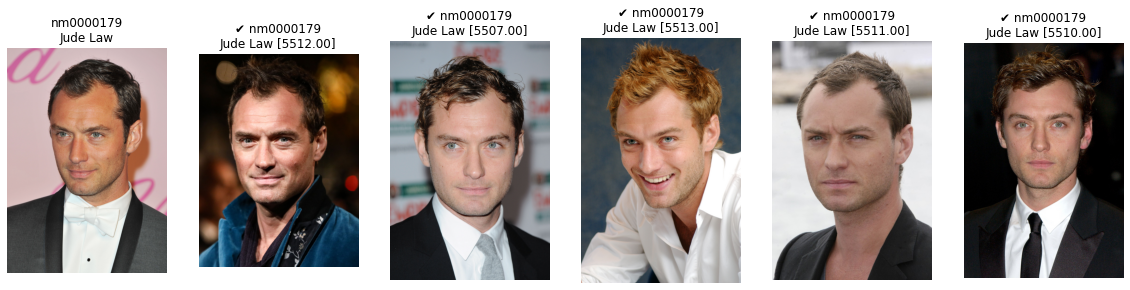

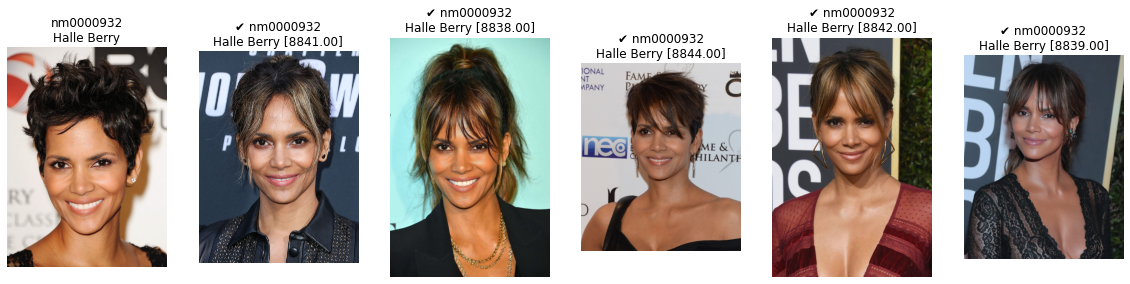

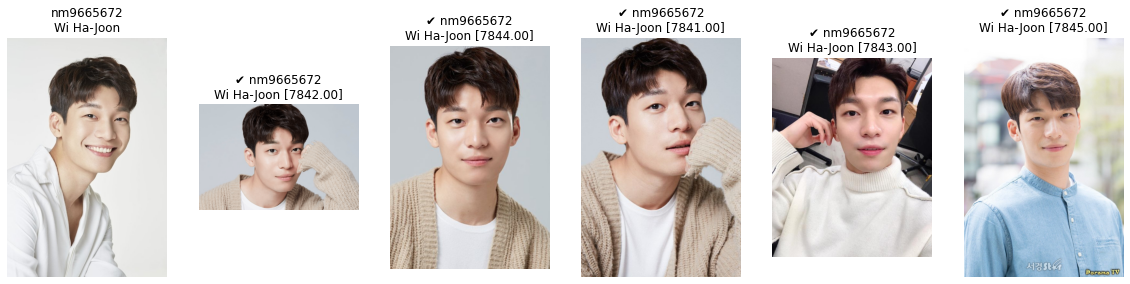

In [83]:
for (_, selected_row), m, d in zip(selected_rows.iterrows(), matches, distances):
    plot_selected_row_with_matches(df, selected_row, matches=m, distances=d)

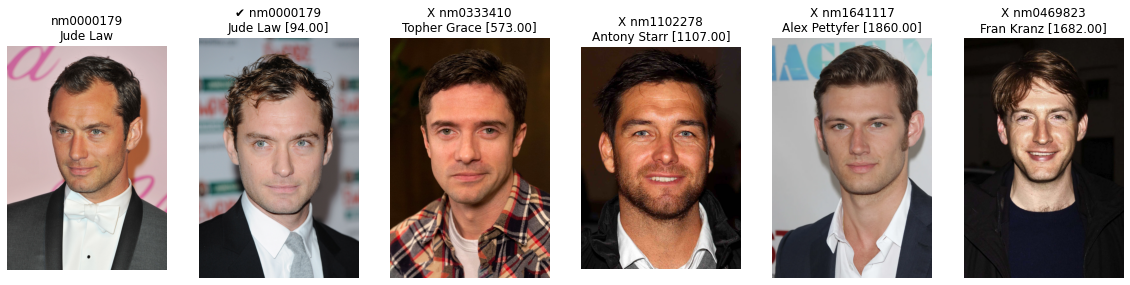

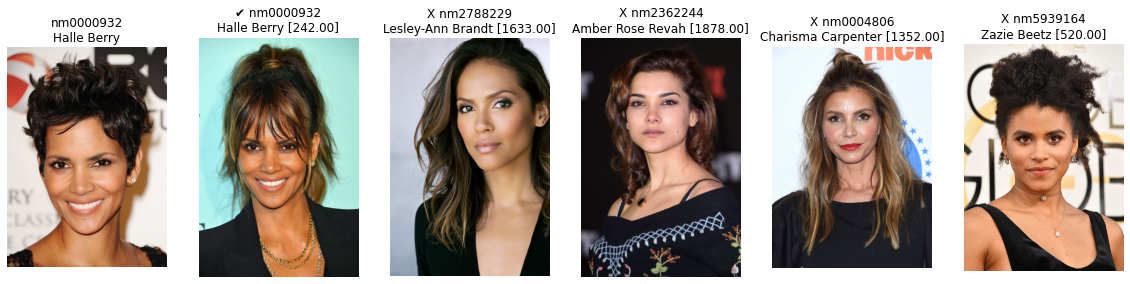

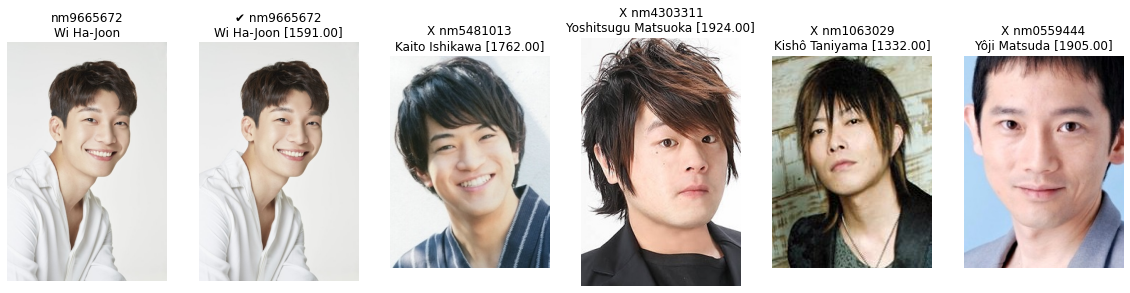

In [84]:
for (_, selected_row), m, d in zip(selected_rows.iterrows(), matches_agg, distances_agg):
    plot_selected_row_with_matches(df_actors, selected_row, matches=m, distances=m)

**Match test images on individual actor images**
Let's test now on a few images that are not in the dataset and that are not actually actors:

- My wife and I (note that the algorithm will match both separately)
- A few historical characters from Ancient Rome and Carthage because they are way too cool

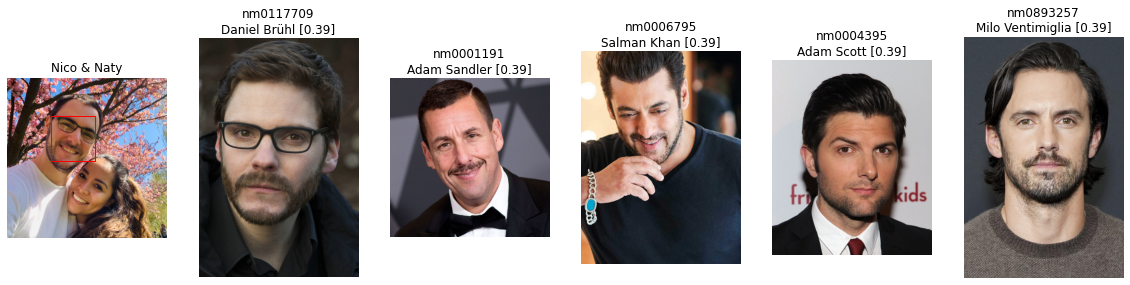

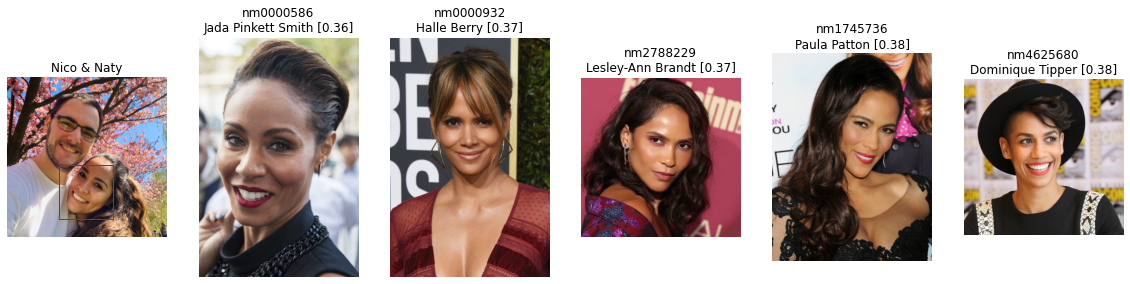

HTTPError: 403 Client Error: Forbidden. Please comply with the User-Agent policy: https://meta.wikimedia.org/wiki/User-Agent_policy for url: https://upload.wikimedia.org/wikipedia/commons/e/ef/Mommsen_p265.jpg

In [86]:
for test_image in test_images:
    results = process_external_image(image_url=test_image["url"], annoy_index=annoy_index, n_comparison=5)
    for res in results:
        plot_image_with_matches(df, test_image["url"], res["matches"], res["distances"], title=test_image["title"], face_locations=res["face_locations"])

**Match test images on aggregated images**

Note that the image of the actor found is a random image for this actor. This is not necessarily the image that best matches the input.

Match test images on aggregated images
(260, 498) 267 -267


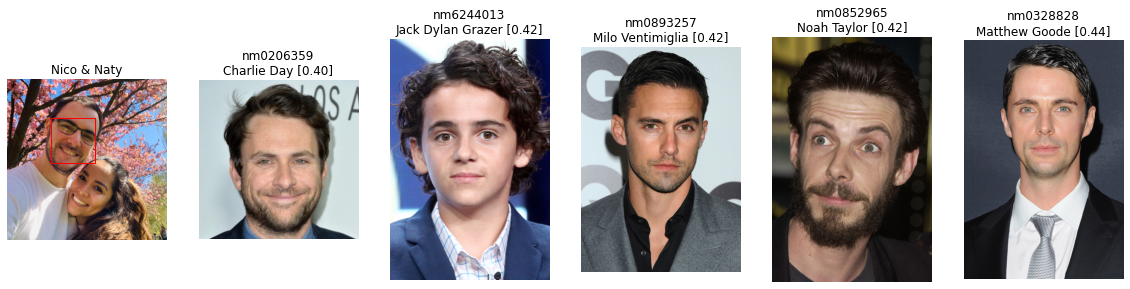

(312, 848) 321 -321


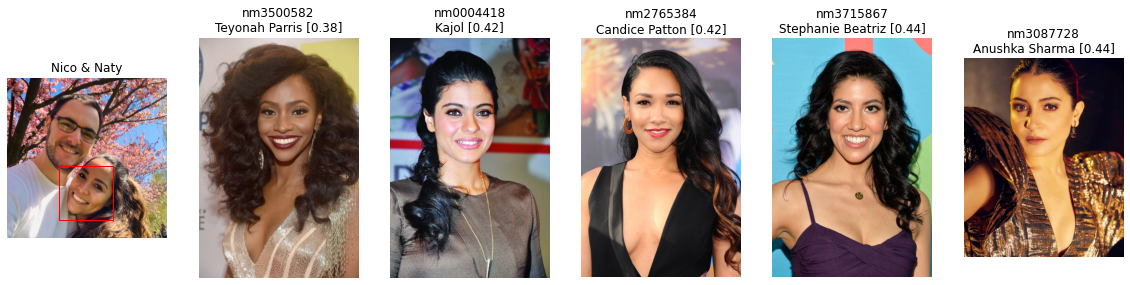

(132, 1020) 666 -666


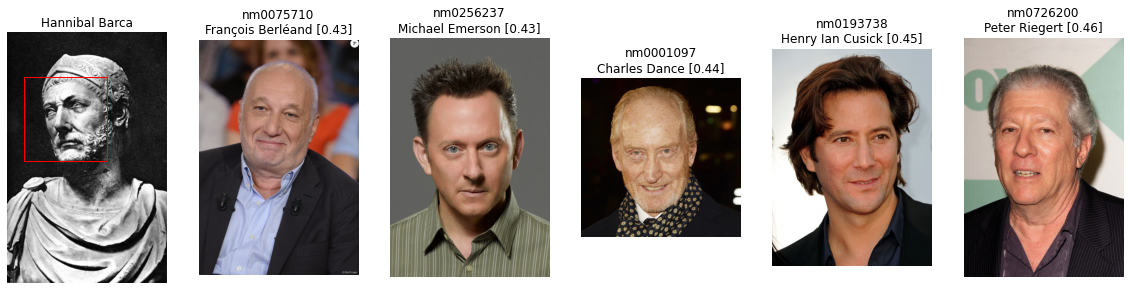

(161, 590) 385 -386


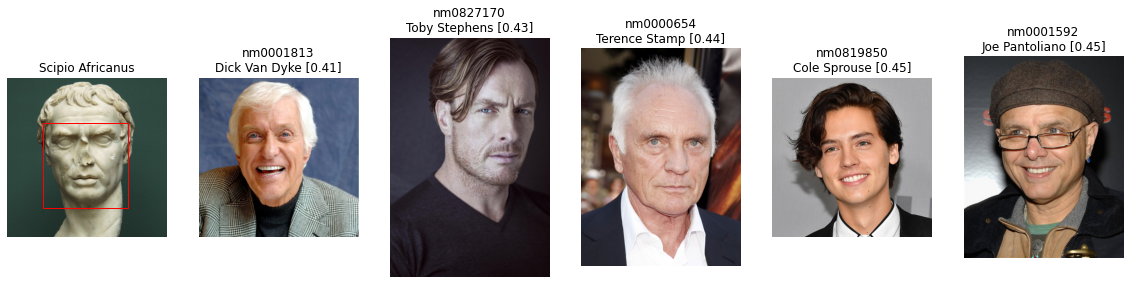

(428, 242) 185 -185


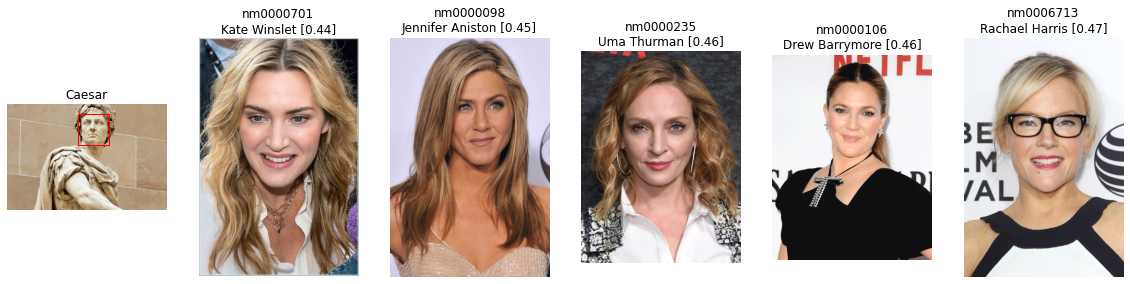

(111, 439) 268 -268


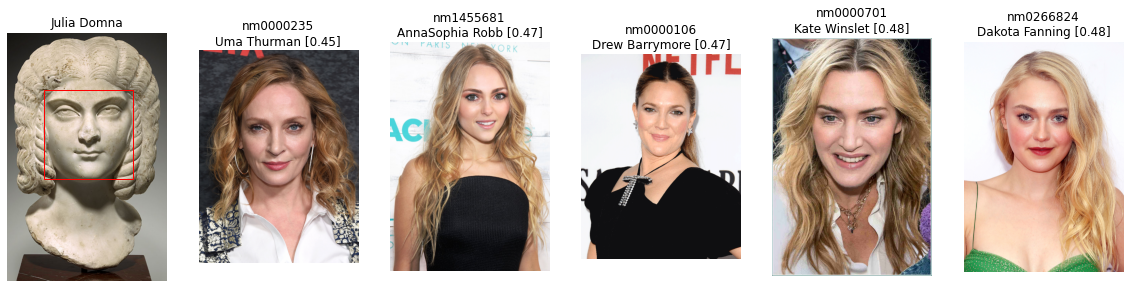

(96, 182) 129 -129


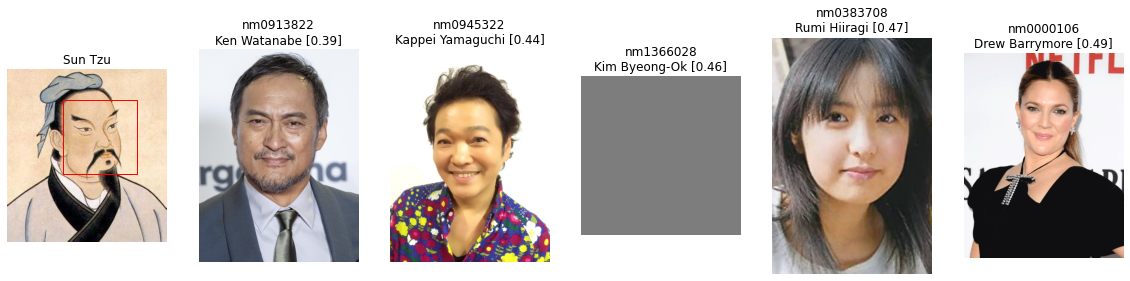

In [ ]:
print("Match test images on aggregated images")
for test_image in test_images:
    results = process_external_image(image_url=test_image["url"], annoy_index=annoy_index_agg, n_comparison=5)
    for res in results:
        plot_image_with_matches(df_actors, test_image["url"], res["matches"], res["distances"], title=test_image["title"], face_locations=res["face_locations"])

### Quantitative evaluation

In [ ]:
def get_match_results(row, n_matches: int = 1):

    matches, distances = annoy_index.get_nns_by_item(row.name, 1+n_matches)[i+1]
    match = df.loc[]

for i in range(5):
    df[[f"match_{i}", f"url_{i}"]] = df.apply(
        lambda x: , axis=1
    )
    df[f"is_match_{i}"] = df[f"match_{i}"] == df["nconst"]

In [6]:
is_match_cols = [f"is_match_{i}" for i in range(5)]

In [6]:
df[is_match_cols].mean()

is_match_0    0.928896
is_match_1    0.896461
is_match_2    0.871421
is_match_3    0.837929
is_match_4    0.806128
dtype: float64

In [11]:
(df[is_match_cols].sum(axis=1) > 0).mean()

0.9486529318541996

In [14]:
df.groupby("nconst").agg({"match_0": "count", "is_match_0": "mean"})

match_0  is_match_0
nconst                        
nm0000092        8    1.000000
nm0000093       19    1.000000
nm0000095        8    1.000000
nm0000100        8    1.000000
nm0000101        8    0.875000
...            ...         ...
nm6806440        9    1.000000
nm6819854        5    1.000000
nm7140802       13    1.000000
nm7415871       10    1.000000
nm9665672        7    0.428571

[1000 rows x 2 columns]

In [16]:
df_actors = pd.read_csv("data/imdb_actors.csv")

In [17]:
df_actors[df_actors.nconst == "nm9665672"]

nconst primaryName  birthYear  averageRating  totalRating  numVotes  \
1020  nm9665672  Wi Ha-Joon       1991           8.13    3888195.8    484393   

      tconst  startYear  lastYear  
1020      36       2015      2022

In [27]:
df[(df.nconst == "nm9665672") & (~df.is_match_0)].iloc[0].contentUrl

'https://i.pinimg.com/736x/ec/00/4b/ec004b1f3bbed6855c6836bda2b441cb.jpg'

In [20]:
df_actors[df_actors.nconst.isin(["nm0814280", "nm0158856", "nm6079248"])]

nconst   primaryName  birthYear  averageRating  totalRating  numVotes  \
420  nm0814280  Kang-ho Song       1967           7.07   10176912.0   1250229   
462  nm0158856  Choi Min-sik       1962           6.92    9159923.2   1222546   
656  nm6079248  Woo-sik Choi       1990           7.78    6355265.0    744449   

     tconst  startYear  lastYear  
420      29       1998      2021  
462      24       1992      2022  
656      85       2011      2022

## Final model

In [87]:
df_tmp = df_actors[["nconst", "primaryName", "contentUrl"]]
df_tmp.columns = ["nconst", "name", "url"]
df_tmp.to_json("models/actors_mapping.json", orient="index", indent=2)

In [89]:
import json 

annoy_index_metadata = dict(metric="angular")
annoy_index_final = build_index(df_actors, n_trees=20, **annoy_index_metadata)
_ = annoy_index_final.save("models/actors_annoy_index.ann")

with open("models/actors_annoy_metadata.json", "w") as f:
    json.dump(annoy_index_metadata, f)